# <center> Сегментация клиентов онлайн магазина подарков

## Постановка задачи


<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Эта задача относится к категории построения рекомендательных систем.

> Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных. Однако [The UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php)  создал набор данных, содержащий фактические транзакции за 2010 и 2011 годы. С ним и будем работать. 

> В нашем распоряжении транзакции, произошедшие в период с 01/12/2010 по 09/12/2011 для базирующейся в Великобритании компании, занимающейся онлайн-розничной торговлей. Компания в основном продает уникальные подарки на все случаи жизни. Многие клиенты компании являются оптовиками.

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

Более подробно в README

Импорт библиотек:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore") # игнорирования (отключения) предупреждений

plt.rcParams["patch.force_edgecolor"] = True # стиль отображения графиков - обводка

C:\Users\Lyudmila\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1. Знакомство со структурой данных

Первым делом необходимо понять, с какими данными предстоит работать, и произвести базовую предобработку данных — перевести признаки в необходимые для дальнейшей работы форматы.

* Проведем статистический анализ исходных данных, посмотрев на основные диапазоны исходных признаков.
* Узнаем, сколько уникальных клиентов совершали транзакции в указанный период.
* Узнаем, из каких стран совершались транзакции.
* Исследуем данные на наличие пропусков и дубликатов.
* Переведем столбцы в корректные форматы (например, даты в формат datetime).

In [96]:
data = pd.read_csv(
    "./data/data.csv", 
    encoding="ISO-8859-1", # Это важно, если в файле есть символы, которые не поддерживаются стандартной кодировкой utf-8
    dtype={'CustomerID': str,'InvoiceID': str} # Указание типов данных столбцов
)
print('Data shape: {}'.format(data.shape))
data.head(10)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047,United Kingdom


In [97]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
print('Date interval {} to {}'.format(data['InvoiceDate'].dt.date.min(), data['InvoiceDate'].dt.date.max()))

Date interval 2010-12-01 to 2011-12-09


Данные за период чуть больше года

In [98]:
data['CustomerID'].nunique()

4372

Всего покупки совершало 4372 уникальных пользователей

In [99]:
unique_cust = data.groupby('CustomerID')['Quantity'].sum().sort_values(ascending=False)/data['Quantity'].sum()
print(unique_cust.head(5))

CustomerID
14646    0.038003
12415    0.014922
14911    0.014910
17450    0.013335
18102    0.012387
Name: Quantity, dtype: float64


Какого-то явно выбивающегося покупателя у нас нет - на 1ого в топе приходится менее 4% заказов, на последующих чуть больше 1%

In [100]:
print('Quantity interval {} to {}'.format(data['Quantity'].min(), data['Quantity'].max()))

Quantity interval -80995 to 80995


Учитывая, что у нас максимальное и минимальное число 80995, можно предположить, что это был самый большой заказ, который вернули, можно проверить это по InvoiceNo	

In [101]:
print(data.loc[data['Quantity'].idxmin(), 'InvoiceNo'], data.loc[data['Quantity'].idxmax(), 'InvoiceNo'])

C581484 581483


Верно, это был возврат того же заказа. В таком случае, интересно, какую долю заказов в целом возвращали - узнаем это после очистки от пропусков и дубликатов

## 2. Преобразование, очистка и анализ данных

### 2.1. Преобразование и очистка данных о транзакциях

#### 2.1.1 Пропуски

Пропуски в столбце с идентификатором клиента (CustomerID) и описанием товара свидетельствуют о некорректных/незавершённых транзакциях. Удалим их из данных.


In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [105]:
data = data.dropna(subset=['CustomerID'], axis=0)

#### 2.1.2. Дубликаты

Проверим данные на наличие дубликатов. Удалим их из данных.


In [106]:
mask = data.duplicated() # Создадим маску дубликатов с помощью метода duplicated() в которой True помечены дубликаты, а False — уникальные записи
duplicates = data[mask]
print(f'Число найденных дубликатов: {duplicates.shape[0]}')

df = data.drop_duplicates() 
print(f'Результирующее число записей: {df.shape[0]}')
df.info()

Число найденных дубликатов: 5225
Результирующее число записей: 401604
<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  object        
 7   Country      401604 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.6+ MB


#### 2.1.3. Транзакции с отрицательным количеством товара

Из приведённых выше инсайтов о данных мы узнали все особенности отмены заказов. Когда мы будем сегментировать клиентов, мы будем определять их покупательскую способность. При расчёте покупательской способности нам будет очень важно учесть возвраты этого клиента.

Чтобы подсчитать количество возвратов, для начала нам надо определить, сколько уникальных товаров указано в транзакции (корзине) для каждой уникальной пары «клиент — заказ»:


In [107]:
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


In [108]:
mask_C = nb_products_per_basket['InvoiceNo'].str.startswith('C')
nb_products_per_basket[mask_C]['InvoiceNo'].count()/nb_products_per_basket['InvoiceNo'].count()

0.16466876971608832

Более 16 % уникальных заказов являются возвратами. 

In [109]:
mask_C = df['InvoiceNo'].str.startswith('C')
df[mask_C]['Quantity'].sum()/df['Quantity'].sum()

-0.05580284378167249

Однако если посчитать в количестве номенклатур возвращенных товаров, то это только 5% от всего проданных товаров

Создадим в наших данных о транзакциях признак `QuantityCanceled`. Этот признак будет указывать на количество отменённого впоследствии товара для каждой транзакции, на которую найдётся противоположная ей транзакция с возвратом. Для транзакций, для которых не было возвратов, признак будет равен 0. Для транзакций, для которых указано отрицательное количество товара, но в данных отсутствует контрагент, признак будет пустым.

Напишем функцию `get_quantity_canceled()`. Эта функция принимает на вход таблицу с транзакциями и возвращает объект `Series` — столбец, в котором указано количество отменённого впоследствии товара для каждой транзакции. Если транзакция не имеет контрагента, этот признак помечается как `NaN`.

Отметим, что эта функция не учитывает сложный случай, когда количество отменённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом). 

In [110]:
def get_quantity_canceled(data):
    """Функция для создания признака количества отменённых заказов. 
    Функция принимает на вход таблицу и возвращает столбец, в котором указано количество отменённого впоследствии товара для кажой транзакции.
    Если транзакция с отрицательным количеством товара не имеет контрагента, данный признак помечается как NaN.

    Args:
        data (DataFrame): таблица с транзакциями

    Returns:
        Series: столбец с количеством отменённого товара
    """
    # Инициализируем нулями Series той же длины, что и столбцы таблицы.
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаём DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента — ничего не делаем
        if (df_test.shape[0] == 0): 
            # Помечаем столбец как пропуск
            quantity_canceled.loc[index] = np.nan
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отменённого товара в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаём количество отменённого товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара больше количества товаров в транзакции-возврате.
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

df['QuantityCanceled'] = get_quantity_canceled(df)

Узнаем, сколько транзакций в данных не имеют контрагентов, и, если их количество невелико, удалим их из данных.

In [111]:
df = df.dropna(subset=['QuantityCanceled'], axis=0)

Таких данных было менее 1%, удалили их 

In [138]:
df = df[df['Quantity']>=0]
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,0.0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,0.0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,0.0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,0.0


Удалили также строки с отрицательным количеством

#### 2.1.4. Специализированные транзакции

Следующая задача — обработаем специальные виды транзакций, которые обозначаются латинскими буквами.

Из документации нам известно, что в данных присутствует шесть специальных видов транзакций. С помощью регулярных выражений найдем такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры).

Специальные операции не характеризуют покупательскую способность клиентов, так как не относятся напрямую к их покупкам, поэтому такие записи нам не нужны. Удалим все специальные транзакции из таблицы.

In [139]:
mask = df['StockCode'].str.contains('^[a-zA-Z]+') # отличие '^[a-zA-Z]+' от '[a-zA-Z]' в том, что первый ищет, чтобы строка начиналась с текста, а символ + после выражения означает "один или более раз".
df = df[~mask]

#### 2.1.5. Транзакции с товарами без стоимости

При просмотре описательных статистик можно заметить, что на некоторые товары установлена цена в 0 фунтов стерлингов. Таких транзакций оказывается менее 1 % — можно удалить их.

In [140]:
mask_2 = df['UnitPrice']==0 
df = df[~mask_2]

#### 2.1.6. Общая стоимость товаров в транзакции

Добавим в наш датасет общую цену заказа (TotalPrice). Она рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Этот признак впоследствии поможет нам рассчитать покупательскую способность каждого из клиентов.

In [141]:
df['TotalPrice'] = df['UnitPrice']*(df['Quantity']-df['QuantityCanceled'])
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0,22.00


Сохраним результат очищения данных в отдельный файл, чтобы впоследствии нам не приходилось повторять эти действия.


In [144]:
df.to_csv('data/df.csv', sep=';', index=False) #не сохраняет в правильном виде дату

In [2]:
df2 = pd.read_csv('data/df.csv', date_format='%Y-%m-%d %H:%M:%S', sep=';')
df2['InvoiceDate'] = pd.to_datetime(df2['InvoiceDate'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391150 entries, 0 to 391149
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         391150 non-null  int64         
 1   StockCode         391150 non-null  object        
 2   Description       391150 non-null  object        
 3   Quantity          391150 non-null  int64         
 4   InvoiceDate       391150 non-null  datetime64[ns]
 5   UnitPrice         391150 non-null  float64       
 6   CustomerID        391150 non-null  int64         
 7   Country           391150 non-null  object        
 8   QuantityCanceled  391150 non-null  float64       
 9   TotalPrice        391150 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 29.8+ MB


### 2.2. Разведывательный анализ

После предобработки исходных данных произведем разведывательный анализ и исследуем транзакции, ответив на следующие вопросы:

* Клиенты из каких стран покупают больше и чаще?
* Какие страны приносят наибольшую сезонную выручку?
* Присутствует ли в продажах сезонность (когда покупают чаще)?
* Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.
* Каково распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции)? 

In [146]:
country_sum = df2['Country'].value_counts(normalize=True)
print(country_sum.head(5))

Country
United Kingdom    0.891914
Germany           0.022096
France            0.020501
EIRE              0.018218
Spain             0.006179
Name: proportion, dtype: float64


In [147]:
country_q = df2.groupby('Country')['Quantity'].sum().sort_values(ascending=False)/df2['Quantity'].sum()
print(country_q.head(5))

Country
United Kingdom    0.823510
Netherlands       0.038947
EIRE              0.027234
Germany           0.022955
France            0.021509
Name: Quantity, dtype: float64


Почти 90% заказов приходится на UK. А если учитывать количество товаров в заказе, то UK также на 1-ом месте, но доля снижается до 82%

Касательно сезонности: для начала разделим дату на саму дату, время, сезон и день недели.



In [3]:
def season_making(arg):
    if arg in [3,4,5]: result = 'spring'
    elif arg in [6,7,8]: result = 'summer'
    elif arg in [9,10,11]: result = 'autumn'
    else: result = 'winter'
    return result

In [4]:
df2['Date'] = df2['InvoiceDate'].dt.date
df2['Time'] = df2['InvoiceDate'].dt.time
df2['Hour'] = df2['InvoiceDate'].dt.hour
df2['Month'] = df2['InvoiceDate'].dt.month
df2['Season'] = df2['InvoiceDate'].dt.month.apply(season_making)
df2['Day_of_Week'] = df2['InvoiceDate'].dt.dayofweek

In [5]:
df2['Season'].value_counts(normalize=True)

Season
autumn    0.386192
winter    0.212346
summer    0.204466
spring    0.196996
Name: proportion, dtype: float64

In [6]:
df2.groupby('Season')['Quantity'].sum().sort_values(ascending=False)/df2['Quantity'].sum()

Season
autumn    0.349012
winter    0.235213
summer    0.219161
spring    0.196614
Name: Quantity, dtype: float64

По осени покупают в целом в 1.5-2 раза выше, чем в другие сезоны. Попробуем посмотреть пиковый месяц, возможно пик осенью связан с началом учебного года. Но строго говоря нельзя говорить о сезонности исходя из наблюдений только за один год. 

In [7]:
df2.groupby('Month')['Quantity'].sum().sort_values(ascending=False)/df2['Quantity'].sum()

Month
11    0.128661
12    0.116001
10    0.114780
9     0.105571
8     0.077230
5     0.072463
7     0.071386
6     0.070545
1     0.067715
3     0.067534
4     0.056618
2     0.051497
Name: Quantity, dtype: float64

Пиковые продажи приходятся на конец года. Предположительно это может быть связано с подготовкой к новогодним праздникам

In [8]:
season_country = df2.groupby(['Country','Season'])['Quantity'].count().sort_values(ascending=False)/df2['Quantity'].count()
season_country.head(10)

Country         Season
United Kingdom  autumn    0.346655
                winter    0.190132
                summer    0.178062
                spring    0.177065
France          autumn    0.008442
Germany         autumn    0.007677
EIRE            autumn    0.007447
Germany         summer    0.005428
                winter    0.004638
France          winter    0.004502
Name: Quantity, dtype: float64

Наибольшую сезонную выручку, ожидаемо, приносит Великобритания, после нее идут Франция и Германия

In [9]:
day_hour = df2.groupby(['Hour','Date'])['Quantity'].sum().groupby('Hour').mean().sort_values(ascending=False) # двойная группировка: 1ая на суммы по день-час, а вторая не среднее по часам из них
day_hour

Hour
12    2692.816393
10    2553.706271
13    2243.211921
11    2119.894737
9     1911.841270
14    1842.262458
15    1783.149502
18    1167.510638
16     958.132576
8      772.750000
17     704.650273
20     679.071429
7      667.826087
19     663.081633
6        1.000000
Name: Quantity, dtype: float64

Если сгруппировать по датам и часам совершения транзакции и найти среднее количество ежедневно поступающих заказов в каждый из часов можно отметить, что больше всего заказов совершается с утра до обеда. На период с 9 до 13 приходится больше половины покупок

Посмотрим в какой стране чаще всего возвращают товары. Чтобы Великобритания не перевешивала чисто по числу покупок, будем смотреть относительную величину: число  возвратов к числу покупок в каждой стране

In [10]:
canceled_ratio = df2.groupby('Country')['QuantityCanceled'].sum()/df2.groupby('Country')['Quantity'].sum()*100
canceled_ratio.sort_values(ascending=False).head(10)

Country
USA               57.933279
Saudi Arabia       6.250000
Czech Republic     5.820896
United Kingdom     5.494187
Spain              4.050642
Japan              3.055812
EIRE               2.884320
Malta              1.670146
France             1.406044
Germany            1.349634
dtype: float64

Неожиданный результат - больше всего возвратов совершается в Штатах - каждый 2ой товар вернули

### 2.3. Построение RFM-таблицы и поиск RFM-выбросов

Мы добрались до самой интересной части. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого построим RFM-таблицу. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов. 

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учётом возвратов).

Когда рассчитаем все характеристики, не дадим столбцам результирующей таблицы соответствующие названия.

In [11]:
# напишем функцию, что мы хотим сделать с каким из столбцов
agg_funcs = {
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum',
    'InvoiceDate': 'max' # последняя покупка
}

clients_df = df2.groupby('CustomerID').agg(agg_funcs) #.reset_index() - в этом случае ID будут как столбец
clients_df.columns = ['Frequency', 'Monetary_value', 'Last_invoice']

# Расчет количества дней от точки отсчета до последней покупки
clients_df['Recency'] = (pd.to_datetime('2011-12-10 00:00:00') - clients_df['Last_invoice']).dt.days

clients_df

,Frequency,Monetary_value,Last_invoice,Recency
CustomerID,,,,
12346,1,0.00,2011-01-18 10:01:00,325
12347,7,4310.00,2011-12-07 15:52:00,2
12348,4,1437.24,2011-09-25 13:13:00,75
12349,1,1457.55,2011-11-21 09:51:00,18
12350,1,294.40,2011-02-02 16:01:00,310
...,...,...,...,...
18280,1,180.60,2011-03-07 09:52:00,277
18281,1,80.82,2011-06-12 10:53:00,180
18282,2,176.60,2011-12-02 11:43:00,7


In [12]:
clients_df = clients_df.drop(['Last_invoice'], axis=1)

Визуализируем каждую из трёх компонент, например, в виде коробчатых диаграмм (boxplot)

In [13]:
boxes = [px.box(clients_df, x=column) for column in clients_df.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Frequency", "Monetary", "Recency"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
#fig.write_html('plotly/boxplot_1.html')
fig.show()

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


In [14]:
clients_df_2 = clients_df.copy()

up_level = 0.95
# Логичен вопрос: а много ли у нас таких квартир, у которых жилая площадь больше, чем суммарная?
mask_Frequency = clients_df_2[clients_df_2['Frequency'] >= clients_df_2['Frequency'].max()*up_level]
clients_df_2 = clients_df_2.drop(mask_Frequency.index, axis=0)

mask_Monetary_value = clients_df_2[clients_df_2['Monetary_value'] >= clients_df_2['Monetary_value'].max()*up_level]
clients_df_2 = clients_df_2.drop(mask_Monetary_value.index, axis=0)

clients_df_2


,Frequency,Monetary_value,Recency
CustomerID,,,
12346,1,0.00,325
12347,7,4310.00,2
12348,4,1437.24,75
12349,1,1457.55,18
12350,1,294.40,310
...,...,...,...
18280,1,180.60,277
18281,1,80.82,180
18282,2,176.60,7


## 3. Моделирование и оценка качества моделей

### 3.1. Кластеризация на основе RFM-характеристик

На основе RFM-признаков кластеризуем клиентов онлайн-магазина подарков с помощью нескольких методов.

Подберем оптимальное количество кластеров для выбранных методов с помощью коэффициента силуэта, перебирая возможные значения от 3 до 10 включительно (большее или меньшее количество кластеров будет нерелеватно для маркетинга). 

Выберем алгоритм с наибольшим коэффициентом силуэта, и сделаем предсказание меток кластеров.


Стандартизируем данные

In [15]:
from sklearn import preprocessing

#Создаем объект 
scaler = preprocessing.StandardScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(clients_df_2)
#Производим преобразование для каждой из выборок
X = scaler.transform(clients_df_2)
X

array([[-0.5014716 , -0.26253289,  2.32316333],
       [ 0.45706029,  0.36368094, -0.90137263],
       [-0.02220566, -0.05371164, -0.17260754],
       ...,
       [-0.34171629, -0.23687411, -0.85145721],
       [ 1.89485812,  0.03380428, -0.89138954],
       [-0.18196097,  0.00441146, -0.50204929]])

**KMEANS**

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_res = []
 
for cluster_num in range(3, 11):
    k_means =  KMeans(n_clusters=cluster_num, init='k-means++', n_init=10, random_state=42)
    k_means.fit(X)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, k_means.predict(X))
    silhouette_res.append((cluster_num, silhouette, len(set(k_means.labels_))) )
df_k_means = pd.DataFrame(silhouette_res, columns=['cluster_num', 'silhouette', 'number_of_clusters'])
df_k_means.sort_values(by = 'silhouette')

,cluster_num,silhouette,number_of_clusters
7,10,0.405398,10
5,8,0.484478,8
6,9,0.484505,9
4,7,0.491649,7
3,6,0.491814,6
0,3,0.563350,3
2,5,0.591597,5
1,4,0.598117,4


In [17]:
kmeans = KMeans(n_clusters=4, random_state=42)
clients_df_2['KMeans'] = kmeans.fit_predict(X)
clients_df_2['KMeans'].value_counts()

KMeans
0    3014
1    1067
2     236
3      14
Name: count, dtype: int64

4 кластера

**DBSCAN**

In [18]:
from sklearn.cluster import DBSCAN

siliuette_list_dbscan = []
 
for eps in np.arange(0.1,3,0.2):
    for min_sample in range(1,20,4):
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        dbscan.fit(X)
        sil_score = silhouette_score(X, dbscan.labels_, metric='euclidean')
        siliuette_list_dbscan.append((eps, min_sample, sil_score, len(set(dbscan.labels_))) )
df_dbscan = pd.DataFrame(siliuette_list_dbscan, columns=['eps', 'min_samples', 'sil_score', 'number_of_clusters'])
df_dbscan.sort_values(by = 'sil_score')

,eps,min_samples,sil_score,number_of_clusters
0,0.1,1,-0.366882,396
3,0.1,13,-0.340645,15
4,0.1,17,-0.327676,12
1,0.1,5,-0.315116,29
5,0.3,1,-0.265761,93
...,...,...,...,...
74,2.9,17,0.899295,2
61,2.5,5,0.903857,2
72,2.9,9,0.907585,2
66,2.7,5,0.911196,2


In [19]:
DBSCAN_cl = DBSCAN(eps=2.9, min_samples=5).fit(X)
clients_df_2['DBSCAN'] = DBSCAN_cl.fit_predict(X)
clients_df_2['DBSCAN'].value_counts()

DBSCAN
 0    4320
-1      11
Name: count, dtype: int64

2 кластера и очень плохо сбалансированы. Видимо, из-за оставшихся выбросов модель плохо срабатывает. Тогда и EM-алгоритм нет смысла пробовать

**Иерархическая кластеризация**

In [20]:
from sklearn.cluster import AgglomerativeClustering

siliuette_list_hierarchical = []
 
for cluster in range(3, 11):
        agglomerative = AgglomerativeClustering(affinity='euclidean',n_clusters=cluster).fit_predict(X)
        sil_score = silhouette_score(X, agglomerative, metric='euclidean')
        siliuette_list_hierarchical.append((cluster, sil_score,len(set(agglomerative)) ) )
        
df_hierarchical = pd.DataFrame(siliuette_list_hierarchical, columns=['cluster', 'sil_score','number_of_clusters'])
 
df_hierarchical.sort_values(by = 'sil_score')

,cluster,sil_score,number_of_clusters
7,10,0.354456,10
5,8,0.448650,8
6,9,0.449041,9
3,6,0.507888,6
4,7,0.508905,7
1,4,0.522507,4
2,5,0.523367,5
0,3,0.564109,3


In [21]:
Agglomerative = AgglomerativeClustering(affinity='euclidean', n_clusters=3).fit(X)
clients_df_2['Agglomerative'] = Agglomerative.fit_predict(X)
clients_df_2['Agglomerative'].value_counts()

Agglomerative
0    3236
1    1064
2      31
Name: count, dtype: int64

3 кластера, как и в KMeans есть один кластер, где существенно меньше наблюдений

### 3.2. Интерпретация результатов кластеризации

Перейдём к интерпретации полученных кластеров.

По результатам видно, что KMeans и иерархическая кластеризация дали схожие результаты - они разделили основной массив данных на 2-3 кластера, а также выделили отдельный кластер для сильно отклоняющихся значений. DBSCAN справился плохо видимо как раз из-за этих выбивающихся значений, следовательно EM нет смысла использовать, результат был бы также не очень хорошим. 

Если судить по показателю силуэта:
- 'KMeans' - 0.598
- 'DBSCAN' - 0.914
- 'Agglomerative' - 0.564

как будто наилучший результат у DBSCAN, однако из-за того, что он почти все данные сложил в один кластер показатель и высокий. Если смотреть объективно, то ждем наилучший показатель кластеризации от KMeans

Более подробные выводы после визуализации

#### 3.2.1. Визуализация кластеров

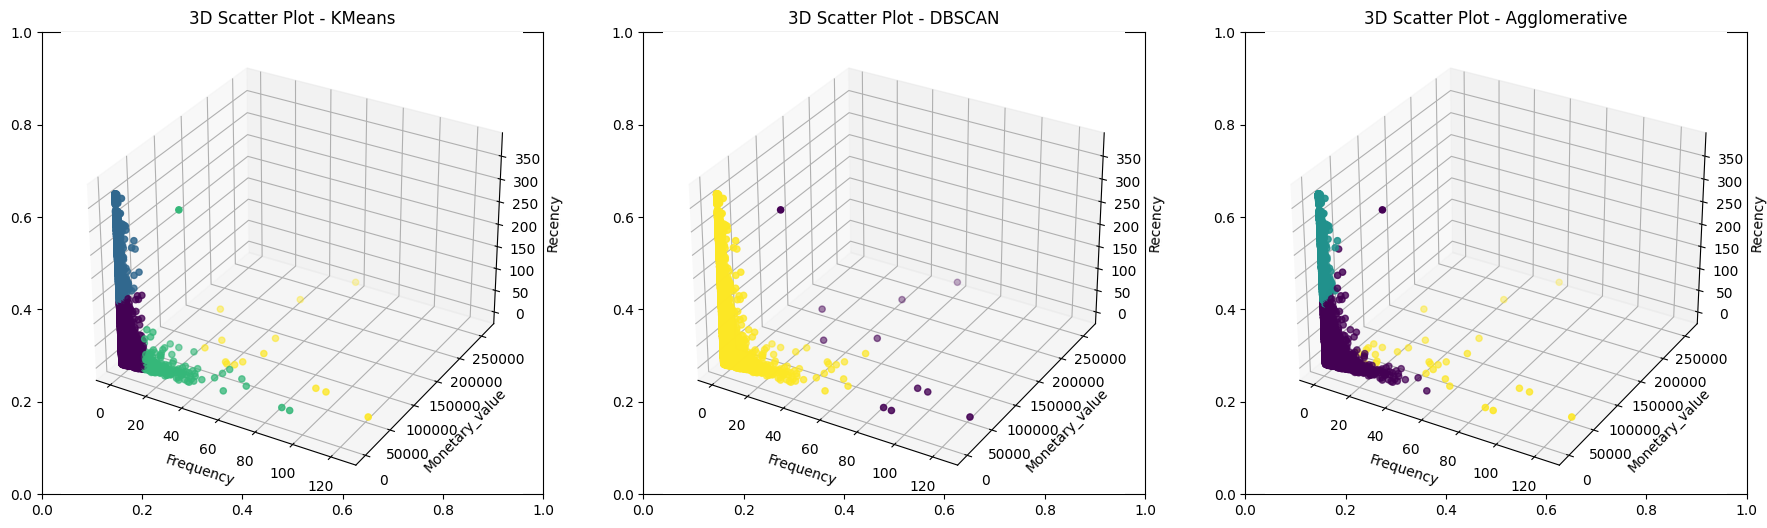

In [22]:
cluster_columns = ['KMeans', 'DBSCAN', 'Agglomerative']

# Создание 3D графиков по всем типам кластеризации
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

for i, cluster_column in enumerate(cluster_columns):
    ax = axes[i]
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')
    
    ax.scatter(clients_df_2['Frequency'], clients_df_2['Monetary_value'], clients_df_2['Recency'], c=clients_df_2[cluster_column])
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Monetary_value')
    ax.set_zlabel('Recency')
    ax.set_title(f'3D Scatter Plot - {cluster_column}')

plt.show()

Видно, что сильно выделяются данные по оси Monetary_value. Т.е. по сути формируется отдельный кластер для тех, кто очень много тратит. Также более очевидна стала причина, почему DBSCAN сработал не очень корректно - все данные кроме "суперплательщиков" расположены крайне близко друг к другу, т.е. метод соседей не будет достаточно показательным. Под наши задачи лучше всего справилась кластеризация KMeans потому что по сути сформировалось 4 группы покупателей: 
- синие - спящие (много покупок, но давно), 
- зеленые - лояльные (часто и активно покупающие), 
- фиолетовые - новички(нечасто, но недавно) 
- желтые - потратившие больше всех денег, и потому выбивающиеся (что-то типа VIP заказов)

#### 3.2.2. Построение профиля кластеров

Далее составим так называемый профиль кластеров. Сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков.

Чтобы результаты было проще интерпретировать, воспользуемся одним из способов визуализации профиля кластеров — **Radar Chart** (полярная диаграмма, или диаграмма паутины). 

Radar Chart часто используется при определении профиля кластеров. На концах паутины откладываются оси, соответствующие признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Запишем все в функцию `plot_cluster_profile()`.


In [23]:
from sklearn.preprocessing import MinMaxScaler

def plot_cluster_profile(grouped_data, n_clusters):
    """Функция для визуализации профиля кластеров в виде полярной диаграммы.

    Args:
        grouped_data (DataFrame): таблица, сгруппированная по номерам кластеров с агрегированными характеристиками объектов.
        n_clusters (int): количество кластеров
    """
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаём список признаков
    features = grouped_data.columns
    # Создаём пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаём полярную диаграмму и добавляем её на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название — номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=500, # ширина (в пикселях)
        height=500, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()

In [24]:
grouped_data = clients_df_2.groupby('KMeans')[['Frequency', 'Monetary_value', 'Recency']].mean()
grouped_data

,Frequency,Monetary_value,Recency
KMeans,,,
0,3.539151,1259.036347,43.774054
1,1.532334,483.259438,248.214620
2,20.444915,9449.323729,11.970339
3,57.071429,91810.435714,7.357143


In [25]:
plot_cluster_profile(grouped_data, 4)

## 4. Улучшение модели через понижение размерности

Несмотря на то, что у нас всего 3 признака, размерность Monetary_value выделяется из общих кластеров можно попробовать прибегунть к методам умешьнения размерности чтобы улучшить результат. Применим методы PCA и t-SNE, а после повторим кластеризацию на наилучшем методе, показавшим себя (KMeans)

**PCA**

<AxesSubplot: >

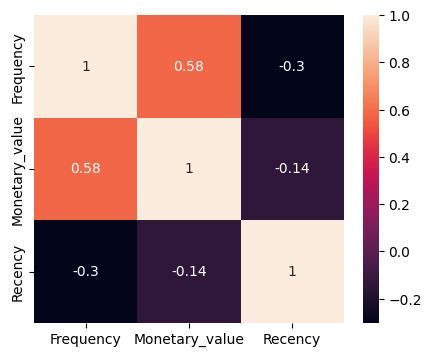

In [29]:
# посмотрим на корреляцию признаков в RFA-таблице
plt.figure(figsize = (5,4))       
sns.heatmap(clients_df_2[['Frequency', 'Monetary_value', 'Recency']].corr(),annot = True)

In [36]:
# Теперь понизим размерность данных
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9, random_state=42).fit(X)
len(pca.components_)

3

In [37]:
# сколько объясняет каждая главная компонента
pca.explained_variance_ratio_

array([0.57420289, 0.29482121, 0.1309759 ])

<AxesSubplot: >

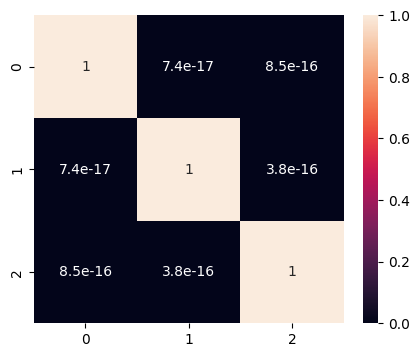

In [41]:
# у новых признаков очень низкая кросс-кореляция
X_pca = pca.fit_transform(X)
corrmat = np.corrcoef(X_pca.transpose()) # для транспонирования массива или матрицы
plt.figure(figsize = (5,4))   
sns.heatmap(corrmat, annot=True)

Теперь подберем новое количество кластеров на данных после PCA

In [42]:
silhouette_res = []
 
for cluster_num in range(3, 11):
    k_means =  KMeans(n_clusters=cluster_num, init='k-means++', n_init=10, random_state=42)
    k_means.fit(X_pca)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X_pca, k_means.predict(X_pca))
    silhouette_res.append((cluster_num, silhouette, len(set(k_means.labels_))) )
df_k_means = pd.DataFrame(silhouette_res, columns=['cluster_num', 'silhouette', 'number_of_clusters'])
df_k_means.sort_values(by = 'silhouette')

,cluster_num,silhouette,number_of_clusters
7,10,0.405398,10
5,8,0.484478,8
6,9,0.484505,9
4,7,0.491649,7
3,6,0.491814,6
0,3,0.563350,3
2,5,0.591597,5
1,4,0.598117,4


In [43]:
kmeans = KMeans(n_clusters=4, random_state=42)
clients_df_2['PCA_KMeans'] = kmeans.fit_predict(X_pca)
clients_df_2['PCA_KMeans'].value_counts()

KMeans
0    3014
1    1067
2     236
3      14
Name: count, dtype: int64

При использовании PCA результаты не изменились, мы также находим 4 кластера, которые соответствуют стандартному KMeans, значит попробуем нелинейные методы понижения размерности

**t-SNE**

Поскольку t-SNE не умеет определять оптимальное количество компонент, попробуем 2 и 3

In [49]:
from sklearn.manifold import TSNE
# создаём объект класса TSNE на 2 компоненты
tsne_2 = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42)
# обучаем модель на данных X и применяем к матрице X уменьшение размерности
X_tsne_2 = tsne_2.fit_transform(X)

In [53]:
silhouette_res = []
 
for cluster_num in range(3, 11):
    k_means =  KMeans(n_clusters=cluster_num, init='k-means++', n_init=10, random_state=42)
    k_means.fit(X_tsne_2)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X_tsne_2, k_means.predict(X_tsne_2))
    silhouette_res.append((cluster_num, silhouette, len(set(k_means.labels_))) )
df_k_means = pd.DataFrame(silhouette_res, columns=['cluster_num', 'silhouette', 'number_of_clusters'])
df_k_means.sort_values(by = 'silhouette')

,cluster_num,silhouette,number_of_clusters
2,5,0.371668,5
0,3,0.382068,3
7,10,0.383831,10
6,9,0.385466,9
1,4,0.385736,4
5,8,0.389072,8
4,7,0.394873,7
3,6,0.399388,6


Оптимальное количество кластеров - 6. Интересно, стоит записать результат и попробовать визуализировать

In [57]:
kmeans = KMeans(n_clusters=6, random_state=42)
clients_df_2['tsne_2_KMeans'] = kmeans.fit_predict(X_tsne_2)
clients_df_2['tsne_2_KMeans'].value_counts()

tsne_2_KMeans
3    881
0    825
2    764
4    667
1    613
5    581
Name: count, dtype: int64

Распределние по кластерам получилось достаточно равномерное - хороший признак

In [51]:
# создаём объект класса TSNE на 3 компоненты
tsne_3 = TSNE(n_components=3, perplexity=30, n_iter=500, random_state=42)
# обучаем модель на данных X и применяем к матрице X уменьшение размерности
X_tsne_3 = tsne_3.fit_transform(X)

In [55]:
silhouette_res = []
 
for cluster_num in range(3, 11):
    k_means =  KMeans(n_clusters=cluster_num, init='k-means++', n_init=10, random_state=42)
    k_means.fit(X_tsne_3)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X_tsne_3, k_means.predict(X_tsne_3))
    silhouette_res.append((cluster_num, silhouette, len(set(k_means.labels_))) )
df_k_means = pd.DataFrame(silhouette_res, columns=['cluster_num', 'silhouette', 'number_of_clusters'])
df_k_means.sort_values(by = 'silhouette')

,cluster_num,silhouette,number_of_clusters
1,4,0.281481,4
0,3,0.292000,3
2,5,0.296608,5
3,6,0.296729,6
5,8,0.323976,8
4,7,0.324893,7
6,9,0.326903,9
7,10,0.335215,10


In [58]:
kmeans = KMeans(n_clusters=10, random_state=42)
clients_df_2['tsne_3_KMeans'] = kmeans.fit_predict(X_tsne_3)
clients_df_2['tsne_3_KMeans'].value_counts()

tsne_3_KMeans
2    639
1    509
8    499
3    470
4    453
9    453
6    384
0    345
7    307
5    272
Name: count, dtype: int64

Здесь тоже распределение вышло достаточно равномерным, посмотрим на визуализации

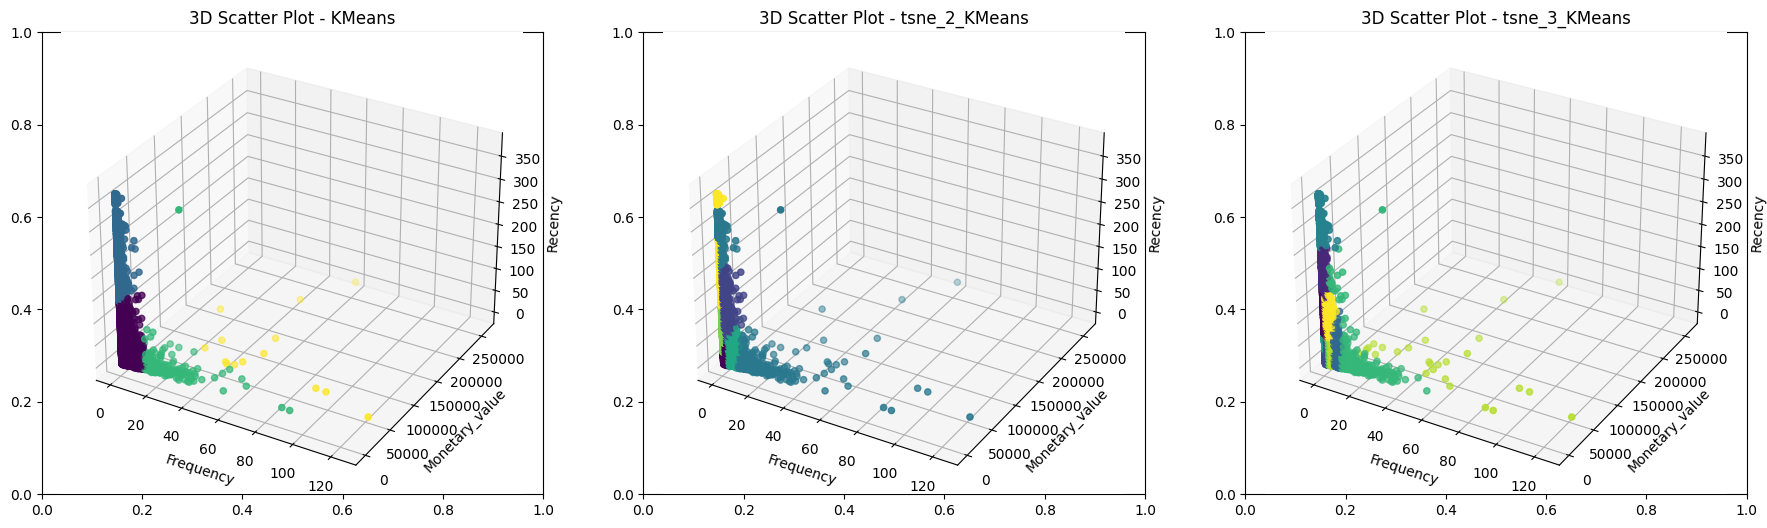

In [61]:
cluster_columns = ['KMeans', 'tsne_2_KMeans', 'tsne_3_KMeans']

fig, axes = plt.subplots(1, 3, figsize=(22, 6))

for i, cluster_column in enumerate(cluster_columns):
    ax = axes[i]
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')
    
    ax.scatter(clients_df_2['Frequency'], clients_df_2['Monetary_value'], clients_df_2['Recency'], c=clients_df_2[cluster_column])
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Monetary_value')
    ax.set_zlabel('Recency')
    ax.set_title(f'3D Scatter Plot - {cluster_column}')

plt.show()

Можно сказать наверняка, что и в группе t-SNE-2 и t-SNE-3 сформировались дополнительные кластеры, которых не было видно на стандартном K-Means. Также можно заметить, что в  t-SNE-3 отчетливо выделяется категория тех, кто тратит много денег, т.е. отдельно выделен кластер по оси Monetary_value, в то время как в  t-SNE-3 там смешаны 2 кластера. Чтобы более подробно рассмотреть кластеры, сделаем 2d-визуализацию отбросив Monetary_value

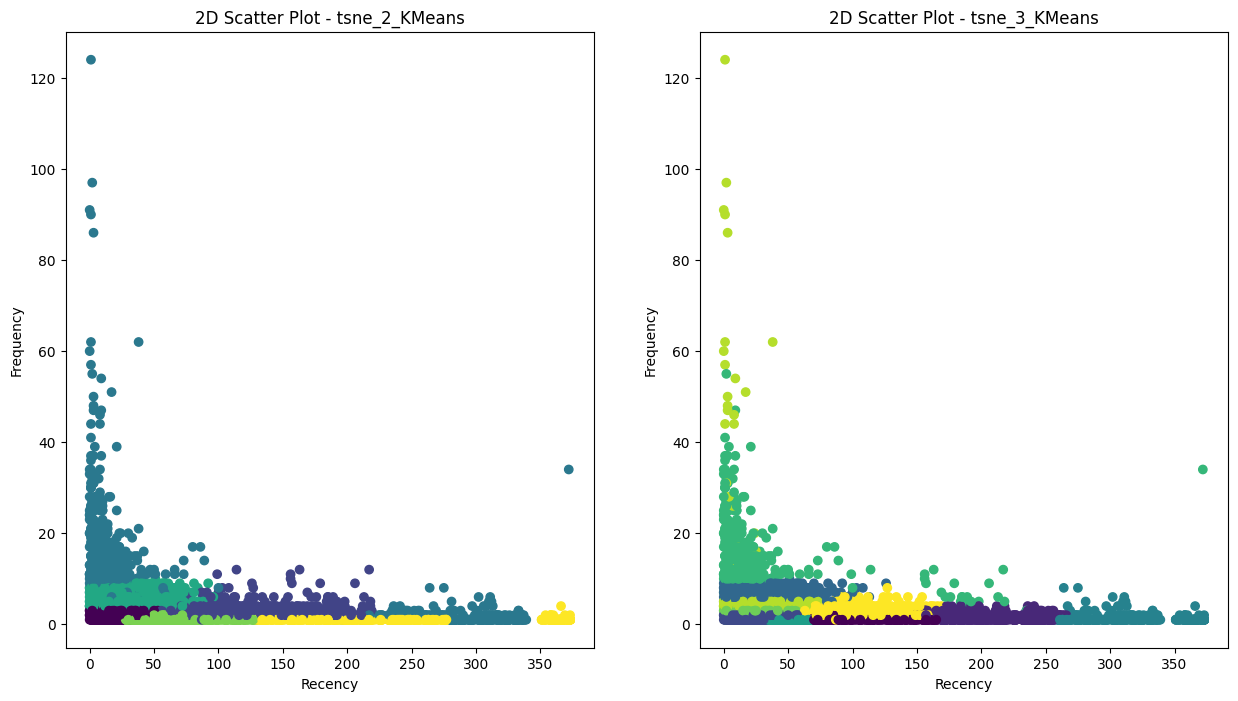

In [73]:
cluster_columns = ['tsne_2_KMeans', 'tsne_3_KMeans']

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

for i, cluster_column in enumerate(cluster_columns):
    ax = axes[i]
    
    ax.scatter(clients_df_2['Recency'], clients_df_2['Frequency'], c=clients_df_2[cluster_column])
    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_title(f'2D  - {cluster_column}')

plt.show()

Какие выводы можно сделать наблюдая за разбиением на кластеры в t-SNE-2 (6 кластеров) и t-SNE-3 (10 кластеров):

- в случае 6 кластеров "лояльные" выделены как один кластер, в то время как при разбиении на 10 кластеров они дробятся на "лояльных" и "VIP" (светло-зеленый и салатовый соответственно)
- "перспективные" и "новички" четко выделены в левом графике (6 кластеров), в то время как в правом среди "новичков" также есть вариации
- если с момента последнего заказа прошло более 150 дней оба подхода формируют 2 различных кластера "спящих": в левой разбивке они прерываются один другим (желтый кластер), а в правой сформированы достаточно четко (фиолетовый и серо-голубой)
- "дрейфующие" и "в зоне риска" достаточно четко выделены в обоих подходах.

Резюмируя можно сказать, что обе разбивки хорошо себя показали, и в зависимости от целей маркетинга может быть использована как более подробная, так и менее подробная кластеризация

In [69]:
grouped_data_tsne_2_KMeans = clients_df_2.groupby('tsne_2_KMeans')[['Frequency', 'Monetary_value', 'Recency']].mean()
plot_cluster_profile(grouped_data_tsne_2_KMeans, 6)

In [70]:
grouped_data_tsne_3_KMeans = clients_df_2.groupby('tsne_3_KMeans')[['Frequency', 'Monetary_value', 'Recency']].mean()
plot_cluster_profile(grouped_data_tsne_3_KMeans, 10)

## 5. Выводы и оформление работы

C помощью KMeans-кластеризации изначально удалось сформировалось 4 группы покупателей: 
- спящие (много покупок, но давно), 
- лояльные (часто и активно покупающие), 
- новички(нечасто, но недавно) 
- потратившие больше всех денег, и потому выбивающиеся (что-то типа VIP клиентов)

Однако позже при помощи нелинейного метода понижения размерности t-SNE удалось сформировать более подробное разделение на кластеры. В случае 2 главных компонент -6 кластеров и в случае 3-ех - 10 кластеров.

- в случае 6 кластеров "лояльные" выделены как один кластер, в то время как при разбиении на 10 кластеров они дробятся на "лояльных" и "VIP" 
- "перспективные" и "новички" четко выделены в случае 6 кластеров, в то время как в более подробной разбивке среди "новичков" есть вариации
- если с момента последнего заказа прошло более 150 дней оба подхода формируют 2 различных кластера "спящих"
- "дрейфующие" и "в зоне риска" достаточно четко выделены в обоих подходах

Резюмируя можно сказать, что метод понижения размерности t-SNE в совокупности с KMeans хорошо себя показали и позволили сформировтаь довольно четкие кластеры в условиях, когда они явно не разделены. В зависимости от целей маркетинга может быть использована как более подробная, так и менее подробная кластеризация